In order to operate GraphGrammar a user have to build node and rule vocabularies the instances of the NodeVocabulary and RuleVocabulary classes and fill them with nodes and rules for the graph. This tutorial provides the description of the creating nodes and rules process.  

Before starting to build your vocabularies import all necessary libs standard and from the `rostok` package 

In [1]:
from cmath import sqrt

import numpy as np

from rostok.block_builder.node_render import (ChronoRevolveJoint,
                                              ChronoTransform, FlatChronoBody,
                                              LinkChronoBody, MountChronoBody)
from rostok.block_builder.transform_srtucture import FrameTransform
from rostok.graph_grammar.node import ROOT, BlockWrapper, GraphGrammar
from rostok.graph_grammar.node_vocabulary import NodeVocabulary
from rostok.graph_grammar.rule_vocabulary import RuleVocabulary
from rostok.graph_grammar.graph_utils import plot_graph

Create and instance of the [class](https://licaibeerlab.github.io/rostok/modules/graph_grammar/node_rule_vocabulary.html#rostok.graph_grammar.node_vocabulary.NodeVocabulary) `NodeVocabulary` and add the imported node ROOT to your vocabulary, the ROOT node is special starting point that have to be in any node vocabulary. 

There are two types of nodes terminal and non-terminal. The non-terminal nodes describe a part of the robot in general without physical properties, for example node "J" represents joints. The nodes are the objects of the class `Node` and terminal nodes actually have only one attribute - label. So one should plan how many structural nodes is needed in the rules. Here we have 14 nodes.

In [2]:
node_vocab = NodeVocabulary()
node_vocab.add_node(ROOT)
node_vocab.create_node("J")
node_vocab.create_node("L")
node_vocab.create_node("F")
node_vocab.create_node("M")
node_vocab.create_node("EF")
node_vocab.create_node("EM")

The second type of nodes are terminal nodes - they represent the physical properties of the nodes in the robot. The physical properties of a node are defined through an instance of the `BlockWrapper` class. To construct the `BlockWrapper` object one have to chose the type of the node by choosing one of the classes from node_render module and set the required for that class parameters.

Here for a joint node we choose `ChronoRevolveJoint` set the rotation around Z axis and set the type of the control - `TORQUE`.


In [3]:
type_of_input = ChronoRevolveJoint.InputType.TORQUE
# Joints
revolve1 = BlockWrapper(ChronoRevolveJoint, ChronoRevolveJoint.Axis.Z, type_of_input)
node_vocab.create_node(label="J1", is_terminal=True, block_wrapper=revolve1)

For each non-terminal nodes one can have several terminal nodes - several details with specific physical properties that have the same function and hence the same non-terminal node. Here we have two palms with different sizes specified with width. The `FlatChronoBody` represents the fixed part of the mechanism and has the form of the box. Here we only set the size of the box and other parameters remain default. The total list of parameters can be seen in the class [documentation](https://licaibeerlab.github.io/rostok/modules/graph_grammar/graph_builder.html#rostok.block_builder.node_render.FlatChronoBody).

In [4]:
flat1 = BlockWrapper(FlatChronoBody, width=0.4, length=0.2)
flat2 = BlockWrapper(FlatChronoBody, width=0.7, length=0.2)
node_vocab.create_node(label="F1", is_terminal=True, block_wrapper=flat1)
node_vocab.create_node(label="F2", is_terminal=True, block_wrapper=flat2)

Next are the links that represents the parts of the fingers. Here we create two different links specified by lengths using class `LinkChronoBody`. It also has more parameters that can be seen in class [documentation](https://licaibeerlab.github.io/rostok/modules/graph_grammar/graph_builder.html#rostok.block_builder.node_render.LinkChronoBody).

In [5]:
link1 = BlockWrapper(LinkChronoBody, length=0.6)
link2 = BlockWrapper(LinkChronoBody, length=0.4)
node_vocab.create_node(label="L1", is_terminal=True, block_wrapper=link1)
node_vocab.create_node(label="L2", is_terminal=True, block_wrapper=link2)

We also add a fingertip that would end the fingers of the grasping mechanism, setting them with two sizes. Other parameters see in documentation.

In [6]:
u1 = BlockWrapper(MountChronoBody, width=0.1, length=0.1)
node_vocab.create_node(label="U1", is_terminal=True, block_wrapper=u1)

Before we had nodes that represented the physical bodies. Here we consider the special case - nodes that represent the coordinates of the base of a finger on the palm. In that set of nodes it is the most difficult part. First we create function that transforms angle in degrees into the rotation that can be set for `Pychrono` object.  


For each palm we create several movements using `FrameTransform` object, that consists of the translation 



In [7]:
# Transforms
MOVE_ZX_PLUS = FrameTransform([0.3, 0, 0.3], [1, 0, 0, 0])
MOVE_ZX_MINUS = FrameTransform([-0.3, 0, -0.3], [1, 0, 0, 0])

MOVE_X_PLUS = FrameTransform([0.3, 0, 0.], [1, 0, 0, 0])
MOVE_Z_PLUS_X_MINUS = FrameTransform([-0.3, 0, 0.3], [1, 0, 0, 0])

For each movement we also create a `BlockWrapper` object 

In [8]:
transform_mzx_plus = BlockWrapper(ChronoTransform, MOVE_ZX_PLUS)
transform_mzx_minus = BlockWrapper(ChronoTransform, MOVE_ZX_MINUS)
transform_mx_plus = BlockWrapper(ChronoTransform, MOVE_X_PLUS)
transform_mz_plus_x_minus = BlockWrapper(ChronoTransform, MOVE_Z_PLUS_X_MINUS)

Now we can use the block wrappers with transforms to create nodes that represents the related position of finger bases in respect to palm. 

In [9]:
node_vocab.create_node(label="T1", is_terminal=True, block_wrapper=transform_mx_plus)
node_vocab.create_node(label="T2", is_terminal=True, block_wrapper=transform_mz_plus_x_minus)
node_vocab.create_node(label="T3", is_terminal=True, block_wrapper=transform_mzx_plus)
node_vocab.create_node(label="T4", is_terminal=True, block_wrapper=transform_mzx_minus)

Now all nodes are set and we can move to the creation of rules. At first create an instance of the `RuleVocabulary` [class](./api/rule_vocabulary.html). Terminal rules are straightforward - they should transform non-terminal nodes into all their terminal/physical representations

In [10]:
rule_vocab = RuleVocabulary(node_vocab)
rule_vocab.create_rule("TerminalFlat1", ["F"], ["F1"], 0, 0)
rule_vocab.create_rule("TerminalFlat2", ["F"], ["F2"], 0, 0)

rule_vocab.create_rule("TerminalL1", ["L"], ["L1"], 0, 0)
rule_vocab.create_rule("TerminalL2", ["L"], ["L2"], 0, 0)

rule_vocab.create_rule("TerminalTransformRX", ["M"], ["T1"], 0, 0)
rule_vocab.create_rule("TerminalTransformLZ", ["M"], ["T2"], 0, 0)
rule_vocab.create_rule("TerminalTransformR", ["M"], ["T3"], 0, 0)
rule_vocab.create_rule("TerminalTransformL", ["M"], ["T4"], 0, 0)
rule_vocab.create_rule("TerminalEndLimb", ["EM"], ["U1"], 0, 0)
rule_vocab.create_rule("TerminalJoint", ["J"], ["J1"], 0, 0)

The most important part of the generative design is the set of non-terminal rules that changes the morphology of the mechanism. Each rule must transform a non-terminal node of the graph into a small graph of non-terminal nodes. It should also specify how to link the in and out edges of the transforming node. The rule is added to a `rule_vocab` using  `create_rule` function of a [RuleVocabulary class](./api/rule_vocabulary.html). The rule must have a unique name, the arguments are:
* The name of the new rule
* Label of the node that the rule changes
* List of nodes in the new graph
* The node to link the in edges 
* The node to link the out edges
* List of edges in the graph that we insert instead of the transformed node  

The user can visualize the added rule using the `rile_vis` function of the `rule_vocab`. The first rule is trivial, it changes the special node `ROOT` with the node `F` that represents the abstract palm

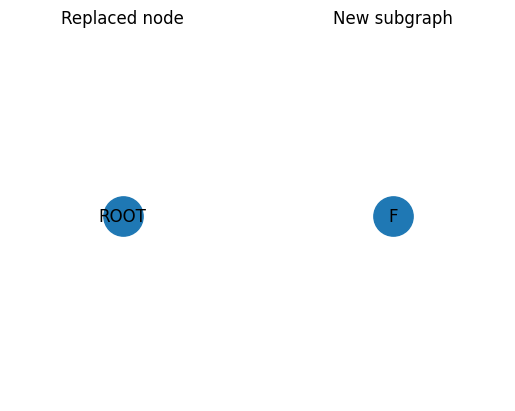

In [11]:
rule_vocab.create_rule("FlatCreate", ["ROOT"], ["F"], 0, 0)
rule_vocab.rule_vis('FlatCreate')

The second rule adds the base for a finger on the palm, the rule changes `F` for the system `F->M->EM`. Notice, the rule removes the changing node, therefore if the node should remain in graph the new subgraph should include it

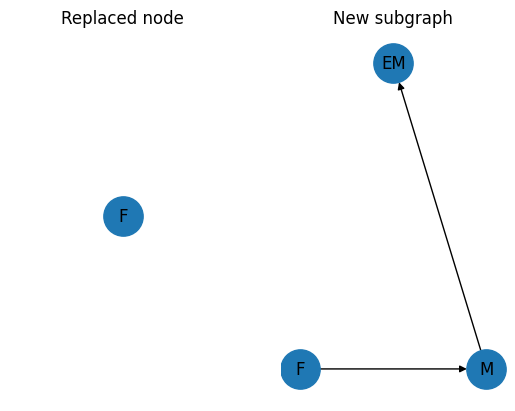

In [12]:
rule_vocab.create_rule("Mount", ["F"], ["F", "M", "EM"], 0, 0, [(0, 1), (1, 2)])
rule_vocab.rule_vis('Mount')

The third rule changes the end of the finger to the joint + link + end of the finger, therefore it adds one moveable link to a finger. The `EM` node remains at the end of the new finger, hence the growth may continue.

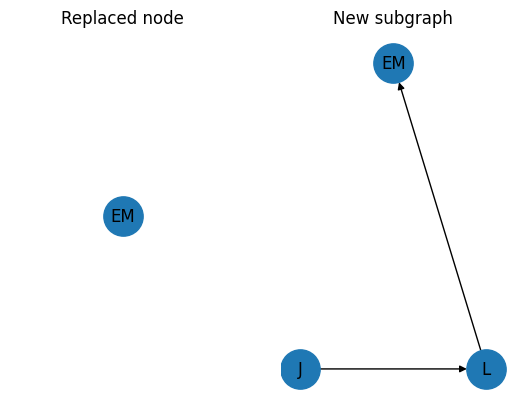

In [13]:
rule_vocab.create_rule("FingerUpper", ["EM"], ["J", "L", "EM"], 0, 2, [(0, 1), (1, 2)])
rule_vocab.rule_vis('FingerUpper')

To create the mechanism with three fingers we should apply Mount rule three times and then add then add as many links as required for the mechanism. One should notice that using this scheme the links will add to the fingers evenly, therefore after adding three links the mechanism will have free fingers with one link each. After constructing the morphology user should add terminal rules to set physical properties to the nodes. Most of rules can be applied to several nodes in the graph, and the `apply_rule` function changes the node closest to palm. This should be taken into consideration in the graph building.

In [14]:
rule_action_non_terminal_three_finger = np.asarray([
    "FlatCreate", "Mount", "Mount", "Mount", "FingerUpper", "FingerUpper", "FingerUpper",
    "FingerUpper", "FingerUpper", "FingerUpper"
])
rule_action_terminal_three_finger = np.asarray([
    "TerminalFlat1", "TerminalL1", "TerminalL1", "TerminalL1", "TerminalL2", "TerminalL2",
    "TerminalL2", "TerminalTransformL", "TerminalTransformLZ", "TerminalTransformRX",
    "TerminalEndLimb", "TerminalEndLimb", "TerminalEndLimb", "TerminalJoint", "TerminalJoint",
    "TerminalJoint", "TerminalJoint", "TerminalJoint", "TerminalJoint"
])
rule_action_three_finger = np.r_[rule_action_non_terminal_three_finger,
                                 rule_action_terminal_three_finger]

def get_terminal_graph_three_finger():
    G = GraphGrammar()
    for i in list(rule_action_three_finger):
        G.apply_rule(rule_vocab.get_rule(i))
    return G

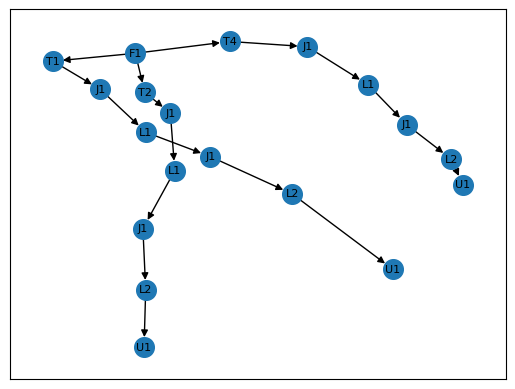

In [15]:
plot_graph(get_terminal_graph_three_finger())

Of course, there is a way to build fingers with different lengths. But it requires the terminalization of a finger end node, to stop the growth of a finger. To get three fingers consisting of one, two and three links we have to add `TerminalEndLimb` rule after three `FingerUpper` upper rules. The rest of the rule list remains the same, but here we cannot devise the list into terminal and non-terminal lists.

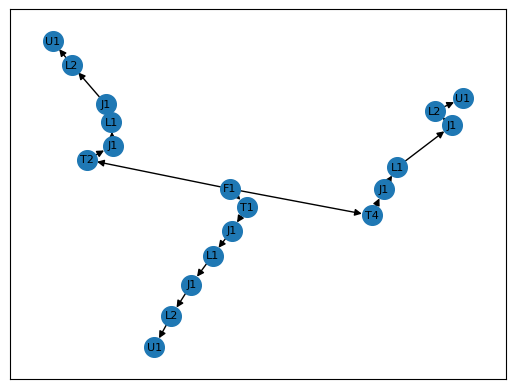

In [16]:
rule_action_with_stop = ["FlatCreate", "Mount", "Mount", "Mount", "FingerUpper", "FingerUpper", "FingerUpper", "TerminalEndLimb", "FingerUpper", "FingerUpper", "FingerUpper",
    "TerminalFlat1", "TerminalL1", "TerminalL1", "TerminalL1", "TerminalL2", "TerminalL2",
    "TerminalL2", "TerminalTransformL", "TerminalTransformLZ", "TerminalTransformRX",
    "TerminalEndLimb", "TerminalEndLimb", "TerminalJoint", "TerminalJoint",
    "TerminalJoint", "TerminalJoint", "TerminalJoint", "TerminalJoint"
]

def get_terminal_graph_three_different_finger():
    G = GraphGrammar()
    for i in list(rule_action_with_stop):
        G.apply_rule(rule_vocab.get_rule(i))
    return G

plot_graph(get_terminal_graph_three_finger())

With that relatively simple set of rules we can build graph for a robot with one to four fingers of arbitrary length.   